# Credit Risk Model

In [213]:
 # Import libraries for analysis, visualization, and model building
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
from xverse.transformer import MonotonicBinning
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.fixes import delayed
from imblearn.combine import SMOTETomek
from sklearn.metrics import precision_recall_curve, auc

## Import Data

In [214]:
df = pd.read_csv("data.csv")

## ***Section 1: Data Review and Dependent Variable Definition***

In [215]:
#has our data imported correctly?
df.head()

,id,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,...,last_credit_pull_d,last_fico_range_high,last_fico_range_low,acc_now_delinq,delinq_amnt,delinq_2yrs,mths_since_last_delinq,mths_since_last_record,inq_last_6mths,inq_last_12m
0,88787390,30000,60 months,761.64,6 years,RENT,100100.0,Verified,Sep-16,Current,...,Dec-16,709,705,0,0,0,26.0,NaN,0,0.0
1,74722660,30000,60 months,692.93,10+ years,MORTGAGE,235000.0,Source Verified,Apr-16,Current,...,Dec-16,649,645,0,0,1,16.0,NaN,1,3.0
2,67919555,16000,60 months,379.39,6 years,RENT,84000.0,Not Verified,Jan-16,Current,...,Dec-16,739,735,0,0,0,80.0,NaN,0,2.0
3,54027458,14000,36 months,439.88,5 years,RENT,50000.0,Source Verified,Jul-15,Fully Paid,...,Oct-16,749,745,0,0,0,NaN,42.0,0,NaN
4,72594974,7500,36 months,252.67,3 years,MORTGAGE,68000.0,Not Verified,Feb-16,Fully Paid,...,Dec-16,709,705,0,0,0,NaN,NaN,2,5.0


In [216]:
#what are the mxn dimensions of our dataset?
df.shape

(80000, 26)

In [217]:
#null values?
df.isnull().sum()

id                            0
loan_amnt                     0
term                          0
installment                   0
emp_length                 4869
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
purpose                       0
addr_state                    0
dti                           0
earliest_cr_line              0
fico_range_low                0
fico_range_high               0
last_credit_pull_d            4
last_fico_range_high          0
last_fico_range_low           0
acc_now_delinq                0
delinq_amnt                   0
delinq_2yrs                   0
mths_since_last_delinq    38214
mths_since_last_record    65468
inq_last_6mths                0
inq_last_12m              42605
dtype: int64

***There appears to be a lot of null values in some columns, depending on our analysis, we may have to impute/drop***

In [218]:
#data types
df.dtypes

id                          int64
loan_amnt                   int64
term                       object
installment               float64
emp_length                 object
home_ownership             object
annual_inc                float64
verification_status        object
issue_d                    object
loan_status                object
purpose                    object
addr_state                 object
dti                       float64
earliest_cr_line           object
fico_range_low              int64
fico_range_high             int64
last_credit_pull_d         object
last_fico_range_high        int64
last_fico_range_low         int64
acc_now_delinq              int64
delinq_amnt                 int64
delinq_2yrs                 int64
mths_since_last_delinq    float64
mths_since_last_record    float64
inq_last_6mths              int64
inq_last_12m              float64
dtype: object

***For the dependent variable, we will work with the 'loan_status' column as it provides a description of the individual's loan and whether or not it has been paid off. Since we are looking to calculate the borrower's chance of default (PD, or Probability of Default) it makes sense that this will be the outcome variable. We will maniuplate this variable so that it can be encoded into either a 0 or 1, 0 being the individual defaulted the loan/the loan was paid late and 1 being the loan was paid off on time***

In [219]:
#first look at unique value in the loan_status column
df.loan_status.value_counts()

Current       62429
Fully Paid    11534
Default        6037
Name: loan_status, dtype: int64

***We will encode loan statuses of 'Default' as 0 and everything else as 1***

In [220]:
df.shape

(80000, 26)

1    73963
0     6037
Name: loan_status2, dtype: int64


<AxesSubplot:title={'center':'Class Balance for 80,000 Instances'}>

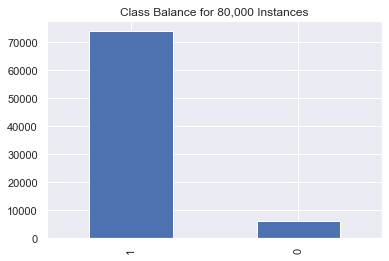

In [221]:
df['loan_status2'] = np.where(df.loc[:, 'loan_status'].isin(['Default']), 0, 1)

#drop original loan_status column
df.drop(columns = ['loan_status'], inplace = True)
#now look at the value counts in this newly calculated column
print(df.loan_status2.value_counts())
df.loan_status2.value_counts().plot(kind = 'bar', title = 'Class Balance for 80,000 Instances')

***There is clearly a class imbalance between our outcome variable. Depending on our analysis, we will have a couple options in terms of building the model and the metrics we use to measure its performance. We want to make sure that the model is correctly classifying borrowers as a 1 or 0 because it understands the patterns in the data rather than classifying a borrower as a 1 by random chaance since there are more than 12.25 times more borrowers who did not default a loan***

## ***Section 2: Data Cleaning***

***In this section I will create several methods to clean the dataset. Firstly, we need to deal with all the missing values. We will examine columns that have >80% null value and drop these columns because if we were to impute them it may lead to innacuracies in the data***

In [222]:
nulls = df.isnull().mean()
nulls[nulls>.8]

mths_since_last_record    0.81835
dtype: float64

***Now we will drop Redundant or non-essential anf forward looking columns. We will drop the mths_since_last_record since >80% of it is null as well as the 'id' column since it is a unique identifier for each borrower and does not provide any indication of the loan_status***

In [223]:
df.columns

Index(['id', 'loan_amnt', 'term', 'installment', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'purpose', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low',
       'fico_range_high', 'last_credit_pull_d', 'last_fico_range_high',
       'last_fico_range_low', 'acc_now_delinq', 'delinq_amnt', 'delinq_2yrs',
       'mths_since_last_delinq', 'mths_since_last_record', 'inq_last_6mths',
       'inq_last_12m', 'loan_status2'],
      dtype='object')

In [224]:
df.drop(columns = ['id', 'mths_since_last_record'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loan_amnt               80000 non-null  int64  
 1   term                    80000 non-null  object 
 2   installment             80000 non-null  float64
 3   emp_length              75131 non-null  object 
 4   home_ownership          80000 non-null  object 
 5   annual_inc              80000 non-null  float64
 6   verification_status     80000 non-null  object 
 7   issue_d                 80000 non-null  object 
 8   purpose                 80000 non-null  object 
 9   addr_state              80000 non-null  object 
 10  dti                     80000 non-null  float64
 11  earliest_cr_line        80000 non-null  object 
 12  fico_range_low          80000 non-null  int64  
 13  fico_range_high         80000 non-null  int64  
 14  last_credit_pull_d      79996 non-null

***Firstly, the emp_length column seems to be of the object data type and we need to convert it to a numeric type to potentially visualize and analyze our borrower data***

In [225]:
df.emp_length.value_counts()

10+ years    26972
2 years       7309
3 years       6350
< 1 year      6259
1 year        5370
5 years       4757
4 years       4748
8 years       3869
6 years       3299
9 years       3178
7 years       3020
Name: emp_length, dtype: int64

In [226]:
def emp_length(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)
#apply to our data
emp_length(df, 'emp_length')

#see updated values 
df.emp_length.value_counts()

<ipython-input-226-ad053ece80ee>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('\+ years', '')


10.0    26972
0.0     11128
2.0      7309
3.0      6350
1.0      5370
5.0      4757
4.0      4748
8.0      3869
6.0      3299
9.0      3178
7.0      3020
Name: emp_length, dtype: int64

***It also apprears that the 'term' column suffers from a similar issue as the emp_length column, so we wil remove the word 'months' from it'***

In [227]:
df.term.value_counts()

36 months    56346
60 months    23654
Name: term, dtype: int64

In [228]:
#first remove the ' months' from the term column and convert to numeric dtype
df['term'] = pd.to_numeric(df.term.map(lambda x: x.replace(' months', '')))

#look at updated values
df.term.value_counts()

36    56346
60    23654
Name: term, dtype: int64

***There are also a few columns that incorporate dates which we want to convert to the Datetime dtype***

In [229]:
df.columns

Index(['loan_amnt', 'term', 'installment', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'purpose', 'addr_state',
       'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low',
       'acc_now_delinq', 'delinq_amnt', 'delinq_2yrs',
       'mths_since_last_delinq', 'inq_last_6mths', 'inq_last_12m',
       'loan_status2'],
      dtype='object')

In [230]:

today_date = pd.to_datetime('2017-01-23') #01/23/2017
#issue_d
df['issue_d'] = pd.to_datetime(df['issue_d'], format = "%b-%y")
df['mths_since_' + 'issue_d'] = round(pd.to_numeric((today_date - df['issue_d']) / np.timedelta64(1, 'M')))
df['mths_since_' + 'issue_d'] = df['mths_since_' + 'issue_d'].apply(lambda x: df['mths_since_' + 'issue_d'].max() if x < 0 else x)
df.drop(columns = ['issue_d'], inplace = True)

#earliest_cr_line
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format = "%b-%y")
df['mths_since_' + 'earliest_cr_line'] = round(pd.to_numeric((today_date - df['earliest_cr_line']) / np.timedelta64(1, 'M')))
df['mths_since_' + 'earliest_cr_line'] = df['mths_since_' + 'earliest_cr_line'].apply(lambda x: df['mths_since_' + 'earliest_cr_line'].max() if x < 0 else x)
df.drop(columns = ['earliest_cr_line'], inplace = True)

#last_credit_pull_d
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format = "%b-%y")
df['mths_since_' + 'last_credit_pull_d'] = round(pd.to_numeric((today_date - df['last_credit_pull_d']) / np.timedelta64(1, 'M')))
df['mths_since_' + 'last_credit_pull_d'] = df['mths_since_' + 'last_credit_pull_d'].apply(lambda x: df['mths_since_' + 'last_credit_pull_d'].max() if x < 0 else x)
df.drop(columns = ['last_credit_pull_d'], inplace = True)

#look at newly created columns
df[['mths_since_issue_d', 'mths_since_earliest_cr_line', 'mths_since_earliest_cr_line']].describe()





,mths_since_issue_d,mths_since_earliest_cr_line,mths_since_earliest_cr_line
count,80000.000000,80000.000000,80000.000000
mean,14.732613,215.349075,215.349075
std,5.751644,91.399978,91.399978
min,5.000000,42.000000,42.000000
25%,10.000000,151.000000,151.000000
50%,15.000000,197.000000,197.000000
75%,19.000000,262.000000,262.000000
max,25.000000,577.000000,577.000000


***After cleaning, look at the dtypes again***

In [231]:
df.dtypes

loan_amnt                          int64
term                               int64
installment                      float64
emp_length                       float64
home_ownership                    object
annual_inc                       float64
verification_status               object
purpose                           object
addr_state                        object
dti                              float64
fico_range_low                     int64
fico_range_high                    int64
last_fico_range_high               int64
last_fico_range_low                int64
acc_now_delinq                     int64
delinq_amnt                        int64
delinq_2yrs                        int64
mths_since_last_delinq           float64
inq_last_6mths                     int64
inq_last_12m                     float64
loan_status2                       int64
mths_since_issue_d               float64
mths_since_earliest_cr_line      float64
mths_since_last_credit_pull_d    float64
dtype: object

In [341]:
df_clean = df.copy(deep = True) #export this dataset 
df_clean.to_csv('cleaned_data.csv')

## Section 3: Analysis

***In this section we will determine 1. if any variables cannot be used to determine PD and 2. if there are any ways to derive additional variables to improve the model's accuracy***

### Feature Selection

**Split the data into categorical and numerical data**

In [233]:
df_cat = df.select_dtypes(include = 'object').copy()
df_num = df.select_dtypes(include = 'number').copy()
df_num = df_num.loc[:, df_num.columns != 'loan_status2']

**Chi-squared test for categorical features**

**Here we performa chi-squared test for indepndence for categorical variables. We want to select features that are highly dependent on the response for modeling**

In [234]:
# define an empty dictionary to store chi-squared test results
chi_squared = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in df_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(df.loan_status2, df_cat[column]))
    chi_squared.setdefault('Feature',[]).append(column)
    chi_squared.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi_squared)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,home_ownership,0.000000e+00
1,verification_status,0.000000e+00
2,purpose,0.000000e+00
3,addr_state,3.310000e-08


***It appears that we can keep all these variables given that they have a p-value <.05***

### ANOVA F-Statistics for numerical features

**Here we apply the ANOVA test to numerical features in order to determine the independence between our independent variables and the output variable. hose variables that have less independence are more liekly to be useful for moddel training**

In [235]:
# since f_class_if does not accept missing values, we will impute missing values with the median as it is not influenced by outliers as opposed to the mean
df_num.fillna(df_num.median(), inplace = True)
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(df_num, df.loan_status2)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': df_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,last_fico_range_high,30190.825328,0.000000e+00
1,last_fico_range_low,29302.808671,0.000000e+00
2,mths_since_issue_d,1458.927152,0.000000e+00
3,fico_range_low,564.339564,0.000000e+00
4,fico_range_high,564.333308,0.000000e+00
5,inq_last_6mths,334.590741,0.000000e+00
6,term,292.483655,0.000000e+00
7,installment,87.083036,0.000000e+00
8,mths_since_earliest_cr_line,66.890934,0.000000e+00
9,loan_amnt,51.410087,0.000000e+00


### Multi-Collinearity?

***We need to determine if there are variables that exhibit multi-collinearity. Though it does not predictions or the precision of the predictions made by the model, it does undermine the statistical significance of the model***

(array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5]),
 [Text(0, 0.5, 'loan_amnt'),
  Text(0, 2.5, 'installment'),
  Text(0, 4.5, 'annual_inc'),
  Text(0, 6.5, 'fico_range_low'),
  Text(0, 8.5, 'last_fico_range_high'),
  Text(0, 10.5, 'acc_now_delinq'),
  Text(0, 12.5, 'delinq_2yrs'),
  Text(0, 14.5, 'inq_last_6mths'),
  Text(0, 16.5, 'mths_since_issue_d'),
  Text(0, 18.5, 'mths_since_last_credit_pull_d')])

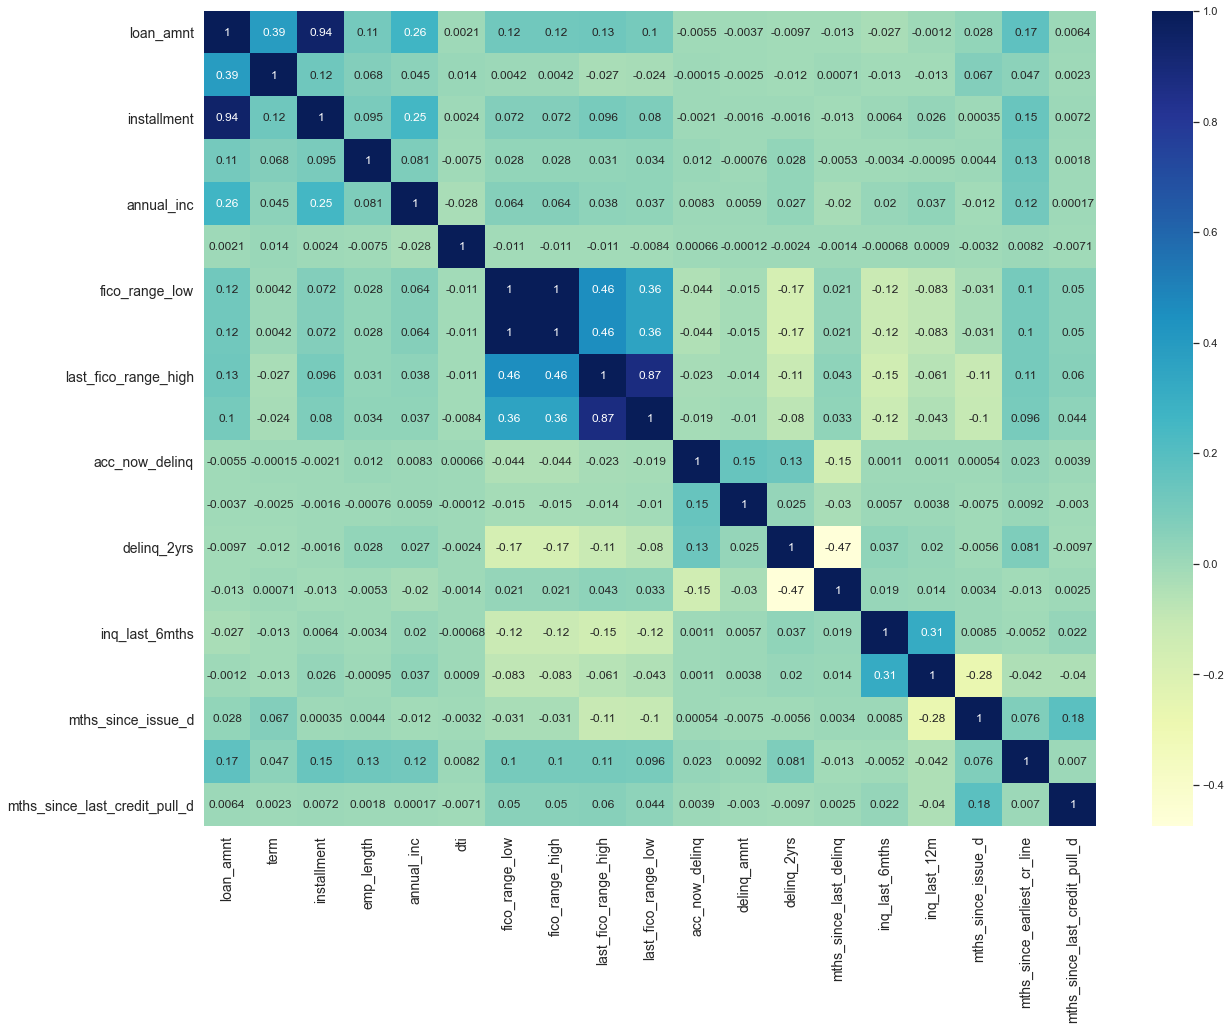

In [236]:
# correlation matrix showing correlation co-effiecients 
corr_matrix = df_num.corr()
heatMap=sns.heatmap(corr_matrix, annot=True,  cmap="YlGnBu", annot_kws={'size':12})
heatmap=plt.gcf()
heatmap.set_size_inches(20,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

**As we can see on the heatmap, the 'loan_amnt', 'installment', 'fico_range_low', 'fico_range_high','last_fico_range_high', 'last_fico_range_low'exhibit multicollinearity so we will drop them from our set of variables**

In [237]:
#drop multicollinear features

df_num.drop(columns = ['loan_amnt', 'installment', 'fico_range_low', 'fico_range_high',
               'last_fico_range_high', 'last_fico_range_low'],inplace = True)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]),
 [Text(0, 0.5, 'term'),
  Text(0, 1.5, 'emp_length'),
  Text(0, 2.5, 'annual_inc'),
  Text(0, 3.5, 'dti'),
  Text(0, 4.5, 'acc_now_delinq'),
  Text(0, 5.5, 'delinq_amnt'),
  Text(0, 6.5, 'delinq_2yrs'),
  Text(0, 7.5, 'mths_since_last_delinq'),
  Text(0, 8.5, 'inq_last_6mths'),
  Text(0, 9.5, 'inq_last_12m'),
  Text(0, 10.5, 'mths_since_issue_d'),
  Text(0, 11.5, 'mths_since_earliest_cr_line'),
  Text(0, 12.5, 'mths_since_last_credit_pull_d')])

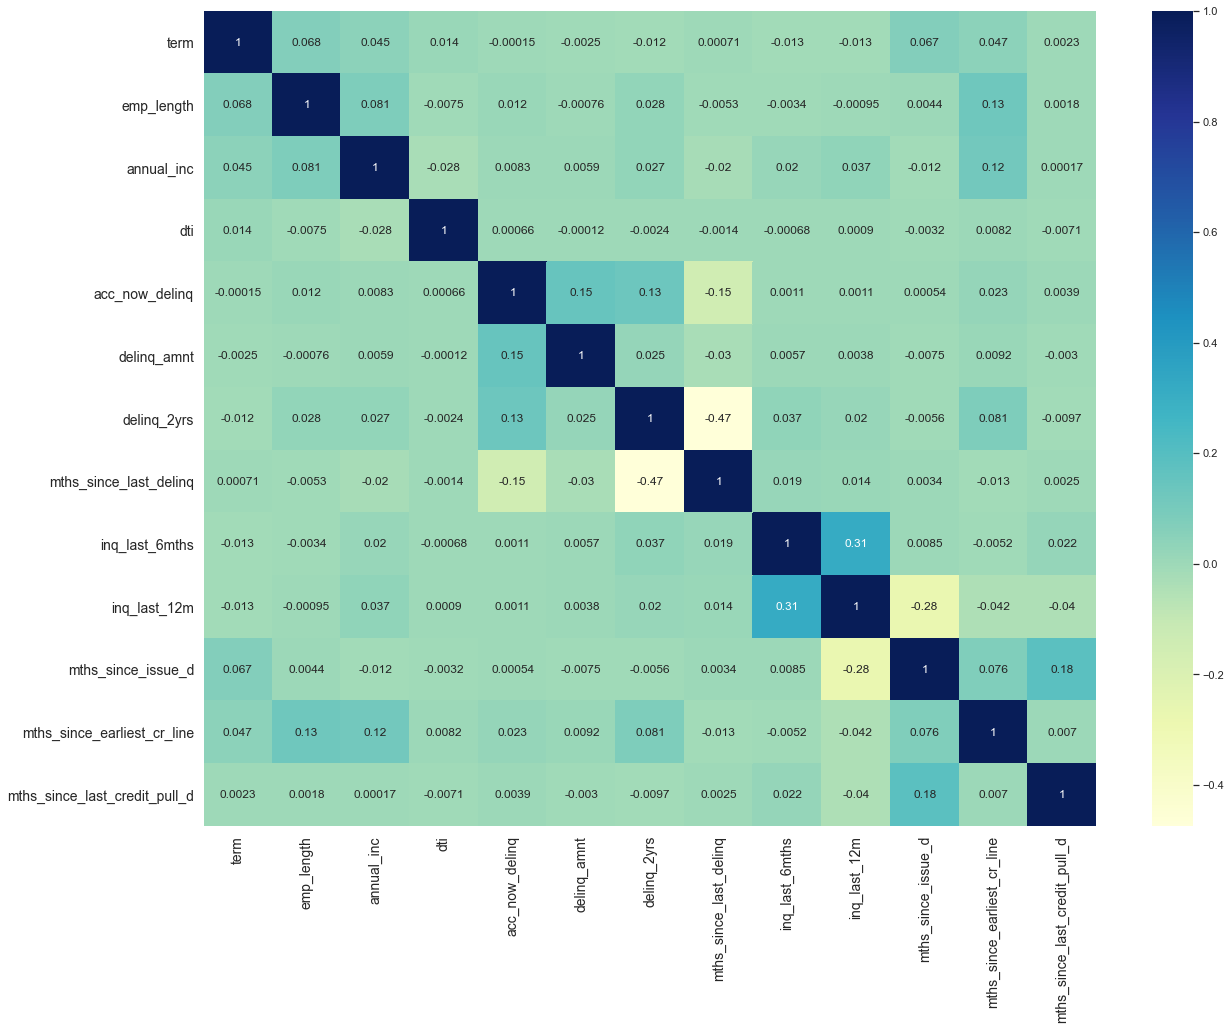

In [238]:
#another heatmap to ensure quality
corr_matrix = df_num.corr()
heatMap=sns.heatmap(corr_matrix, annot=True,  cmap="YlGnBu", annot_kws={'size':12})
heatmap=plt.gcf()
heatmap.set_size_inches(20,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

***Now, combine all the selected features and finer version of the dataset***

In [239]:
df2 = pd.concat([df_num, df_cat], axis = 1)
df2.shape

(80000, 17)

***To answer the question "Are there any ways to derive additional variables that would improve the model prediction accuracy?" we can begin by one-hot encoding categorical variables. This will be completed in the analysis section when we perform feature engineering and WoE/IV Analysis***

In [240]:
df2.head()

,term,emp_length,annual_inc,dti,acc_now_delinq,delinq_amnt,delinq_2yrs,mths_since_last_delinq,inq_last_6mths,inq_last_12m,mths_since_issue_d,mths_since_earliest_cr_line,mths_since_last_credit_pull_d,home_ownership,verification_status,purpose,addr_state
0,60,6.0,100100.0,27.42,0,0,0,26.0,0,0.0,5.0,493.0,2.0,RENT,Verified,debt_consolidation,SC
1,60,10.0,235000.0,7.50,0,0,1,16.0,1,3.0,10.0,265.0,2.0,MORTGAGE,Source Verified,home_improvement,PA
2,60,6.0,84000.0,27.87,0,0,0,80.0,0,2.0,13.0,222.0,2.0,RENT,Not Verified,debt_consolidation,FL
3,36,5.0,50000.0,21.65,0,0,0,31.0,0,1.0,19.0,244.0,4.0,RENT,Source Verified,debt_consolidation,WV
4,36,3.0,68000.0,29.09,0,0,0,31.0,2,5.0,12.0,195.0,2.0,MORTGAGE,Not Verified,debt_consolidation,OH


### WoE Binning and Feature Engineering

**Weight of Evidence (WoE) is a measure of the predictive power of an independent variables in relation to the target variable. WoE can meausre the extent a specific feature can differentiate between target classes ie: paying a loan vs defaulting**

**Information Values (IV) ranks features based on relative importance**

In [241]:
#revisit the numerical and categorical datasets made in the previous section. Add our target variable to it
df_num['loan_status2'] = df.loan_status2

In [242]:
#function to calculate weight of evidence and information value

def iv_woe(df_num, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = df_num.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (df_num[ivars].dtype.kind in 'bifc') and (len(np.unique(df_num[ivars]))>10):
            binned_x = pd.qcut(df2[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': df_num[target]})
        else:
            d0 = pd.DataFrame({'x': df_num[ivars], 'y': df_num[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF
iv, woe = iv_woe(df_num, target='loan_status2', bins=20)




Information value of term is 0.048749
Information value of emp_length is 0.007254
Information value of annual_inc is 0.020722
Information value of dti is 0.053941
Information value of acc_now_delinq is 0.001765
Information value of delinq_amnt is 0.0
Information value of delinq_2yrs is 0.002114
Information value of mths_since_last_delinq is 0.004847
Information value of inq_last_6mths is 0.054067
Information value of inq_last_12m is 0.045621
Information value of mths_since_issue_d is 0.31696
Information value of mths_since_earliest_cr_line is 0.017954
Information value of mths_since_last_credit_pull_d is 0.208946


In [243]:
iv.head()

,Variable,IV
0,term,0.048749
0,emp_length,0.007254
0,annual_inc,0.020722
0,dti,0.053941
0,acc_now_delinq,0.001765


In [244]:
woe.head()

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,term,36,56346,52676,0.712194,3670,0.607918,0.158311,0.016508
1,term,60,23654,21287,0.287806,2367,0.392082,-0.309185,0.032241
0,emp_length,"(-0.001, 1.0]",16498,15113,0.204332,1385,0.229419,-0.115803,0.002905
1,emp_length,"(1.0, 2.0]",7309,6732,0.091018,577,0.095577,-0.048872,0.000223
2,emp_length,"(2.0, 3.0]",6350,5863,0.079269,487,0.080669,-0.017505,0.000025


In [245]:
iv.shape

(13, 2)

In [246]:
x = iv.Variable.loc[(iv['IV'] <.02) | (iv['IV']>0.5)].tolist()
x

['emp_length',
 'acc_now_delinq',
 'delinq_amnt',
 'delinq_2yrs',
 'mths_since_last_delinq',
 'mths_since_earliest_cr_line']

In [247]:
#drop variables with low information values
df_num.drop(columns = x, inplace = True)
df_num.shape

(80000, 8)

In [248]:
df_cat.columns

Index(['home_ownership', 'verification_status', 'purpose', 'addr_state'], dtype='object')

In [249]:
#create dummy variables for categorical columns
dummies = [pd.get_dummies(df_cat.home_ownership, prefix = 'home_ownership'),
             pd.get_dummies(df_cat.verification_status, prefix = 'verification_status'),
             pd.get_dummies(df_cat.purpose, prefix = 'purpose'),
             pd.get_dummies(df_cat.addr_state, prefix = 'addr_state')]

df_dummies = pd.concat(dummies, axis =1)
df_dummies.head()


,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,0,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [250]:
Y = df.loan_status2

In [251]:
# function to calculate woe of categorical features

def woe_categorical(df, cat_feature, good_bad_df):
    df = pd.concat([df[cat_feature], good_bad_df], axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df


# function to plot woe values 
# We set the default style of the graphs to the seaborn style. 
sns.set()
# Below we define a function for plotting WoE across categories that takes 2 arguments: a dataframe and a number.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)    


### Examine WoE For each Categorical Variable and Plot

In [252]:
df_home_ownership = woe_categorical(df_cat, 'home_ownership', Y)
df_home_ownership.head()

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,RENT,31629,0.914035,0.395363,28910.0,2719.0,0.390871,0.450389,-0.141734,NaN,NaN,inf
1,OWN,9316,0.922714,0.116450,8596.0,720.0,0.116220,0.119265,-0.025857,0.008679,0.115878,inf
2,MORTGAGE,39054,0.933477,0.488175,36456.0,2598.0,0.492895,0.430346,0.135706,0.010763,0.161563,inf
3,ANY,1,1.000000,0.000013,1.0,0.0,0.000014,0.000000,inf,0.066523,inf,inf


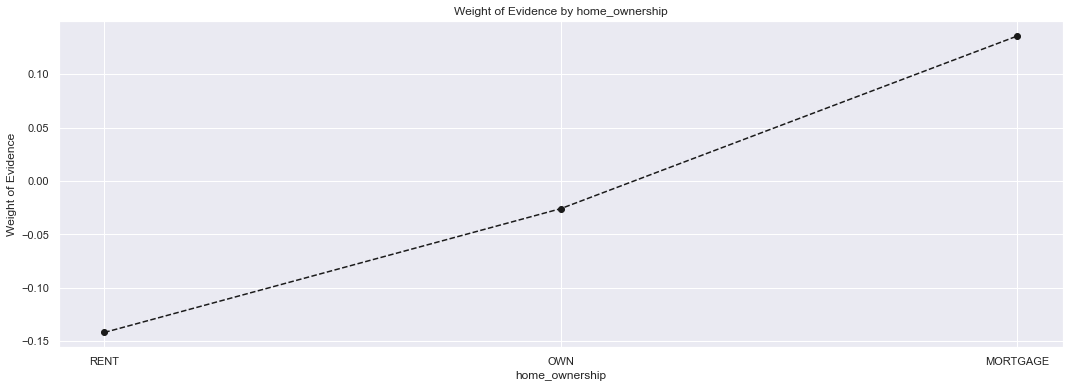

In [253]:
plot_by_woe(df_home_ownership)

**Bin ANY and RENT together**

In [254]:
df_verification = woe_categorical(df_cat, 'verification_status', Y)
df_verification.head()

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Verified,23349,0.903251,0.291863,21090.0,2259.0,0.285143,0.374192,-0.271781,NaN,NaN,0.061686
1,Source Verified,33189,0.923288,0.414863,30643.0,2546.0,0.414302,0.421733,-0.017777,0.020037,0.254004,0.061686
2,Not Verified,23462,0.947490,0.293275,22230.0,1232.0,0.300556,0.204075,0.387146,0.024202,0.404923,0.061686


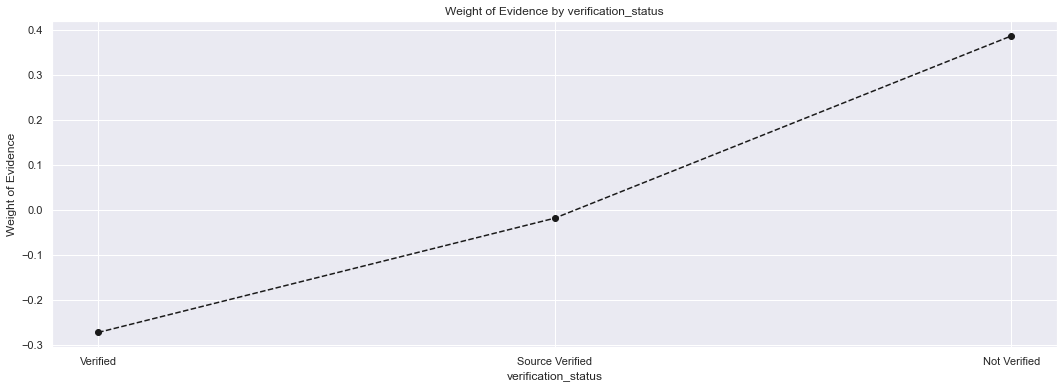

In [255]:
plot_by_woe(df_verification)

**The verification variable has different WoE values and can therefore be used as separate variables**

In [256]:
df_purpose = woe_categorical(df_cat, 'purpose', Y)
df_purpose

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,renewable_energy,51,0.843137,0.000638,43.0,8.0,0.000581,0.001325,-0.823899,NaN,NaN,inf
1,small_business,754,0.887268,0.009425,669.0,85.0,0.009045,0.014080,-0.442525,0.044131,0.381374,inf
2,house,328,0.890244,0.004100,292.0,36.0,0.003948,0.005963,-0.412423,0.002976,0.030102,inf
3,other,4352,0.918199,0.054400,3996.0,356.0,0.054027,0.058970,-0.087539,0.027955,0.324884,inf
4,medical,832,0.918269,0.010400,764.0,68.0,0.010329,0.011264,-0.086598,0.000071,0.000942,inf
5,debt_consolidation,46721,0.918581,0.584013,42917.0,3804.0,0.580250,0.630114,-0.082443,0.000311,0.004155,inf
6,major_purchase,1647,0.922283,0.020588,1519.0,128.0,0.020537,0.021203,-0.031881,0.003702,0.050562,inf
7,vacation,503,0.922465,0.006287,464.0,39.0,0.006273,0.006460,-0.029335,0.000182,0.002546,inf
8,moving,532,0.924812,0.006650,492.0,40.0,0.006652,0.006626,0.003941,0.002347,0.033276,inf
9,home_improvement,5050,0.935842,0.063125,4726.0,324.0,0.063897,0.053669,0.174433,0.011030,0.170492,inf


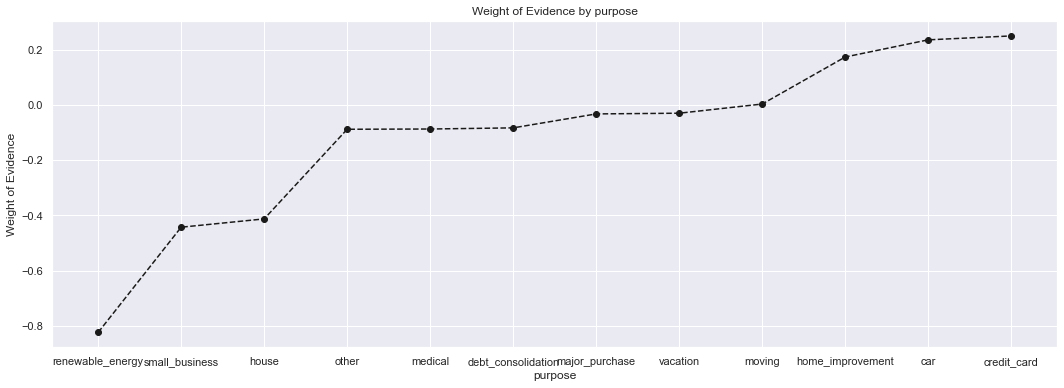

In [257]:
plot_by_woe(df_purpose)

In [258]:
df_addr_state = woe_categorical(df_cat, 'addr_state', Y)
df_addr_state

,addr_state,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,AR,632,0.889241,0.007900,562.0,70.0,0.007598,0.011595,-0.422651,NaN,NaN,0.022978
1,AL,966,0.894410,0.012075,864.0,102.0,0.011682,0.016896,-0.369058,0.005169,0.053593,0.022978
2,OK,741,0.901484,0.009262,668.0,73.0,0.009032,0.012092,-0.291829,0.007075,0.077229,0.022978
3,LA,940,0.902128,0.011750,848.0,92.0,0.011465,0.015239,-0.284566,0.000643,0.007263,0.022978
4,NC,2283,0.910206,0.028538,2078.0,205.0,0.028095,0.033957,-0.189507,0.008078,0.095059,0.022978
5,NV,1117,0.911370,0.013962,1018.0,99.0,0.013764,0.016399,-0.175182,0.001164,0.014324,0.022978
6,MT,219,0.913242,0.002737,200.0,19.0,0.002704,0.003147,-0.151779,0.001872,0.023403,0.022978
7,NY,6574,0.915120,0.082175,6016.0,558.0,0.081338,0.092430,-0.127839,0.001878,0.023941,0.022978
8,TN,1297,0.915189,0.016213,1187.0,110.0,0.016049,0.018221,-0.126954,0.000069,0.000885,0.022978
9,NM,441,0.916100,0.005513,404.0,37.0,0.005462,0.006129,-0.115161,0.000911,0.011793,0.022978


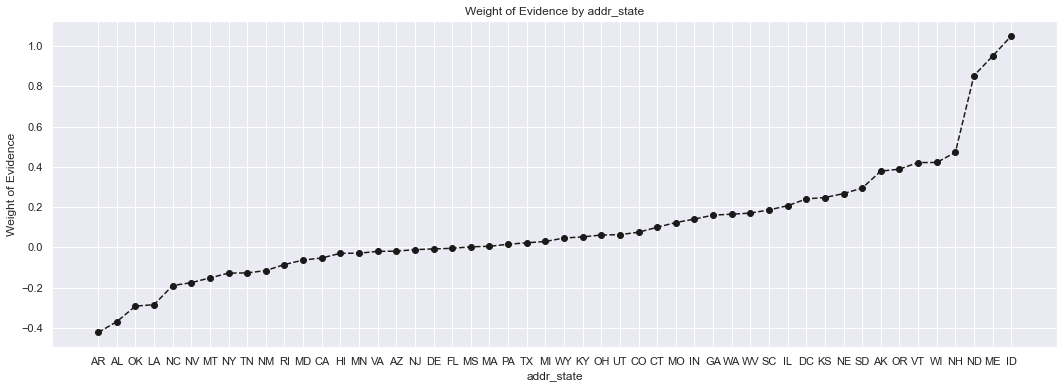

In [259]:
plot_by_woe(df_addr_state)

We will use both WOE and the number of observations in our analysis. Categories with similar WOE but different observations with should not be combine together. The reason been that the number of observations could influence the WOE values. Also, categories with both similar WOE and observations greater than 5% can be combined together to form a new category. This  process will be used for  the rest of analysis.The categories to be combined as follows:

1. NE, NV, HI, FL, AL
2. NY
3. LA, NM, OK, NC, MO, MD, NJ, VA
4. CA
5. AZ, MI, UT, TN, AR, PA
6. RI, OH, KY, DE, MN, SD, MA, IN
7. GA, WA
8. WI, OR
9. TX
10. IL, CT,MT
11. CO, SC
12. KS, VT, AK, MS
13. NH, WV, WY, DC

### Examine WoE For each Continuous Variable and Plot

In [260]:
def woe_continuous(df, cat_feature, good_bad_df):
    df = pd.concat([df[cat_feature], good_bad_df], axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
#     df = df.sort_values(['WoE'])
#     df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [261]:
woe_continuous(df_num, 'term', Y)

,term,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,36,56346,0.934867,0.704325,52676.0,3670.0,0.712194,0.607918,0.158311,NaN,NaN,0.048749
1,60,23654,0.899932,0.295675,21287.0,2367.0,0.287806,0.392082,-0.309185,0.034934,0.467495,0.048749


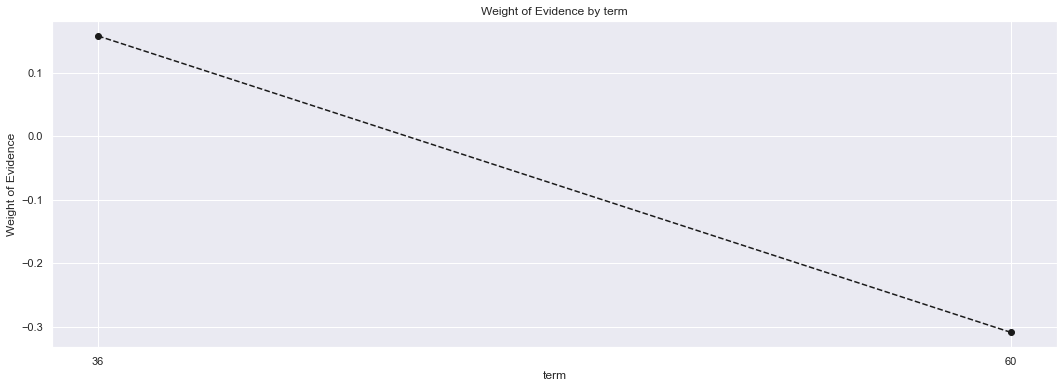

In [262]:
plot_by_woe(woe_continuous(df_num, 'term', Y))

In [263]:
woe_continuous(df_num, 'annual_inc', Y)

/Users/sk/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,annual_inc,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,1,0.0,0.000013,0.0,1.0,0.000000,0.000166,-inf,NaN,NaN,inf
1,1.0,2,1.0,0.000025,2.0,0.0,0.000027,0.000000,inf,1.0,inf,inf
2,1000.0,1,1.0,0.000013,1.0,0.0,0.000014,0.000000,inf,0.0,NaN,inf
3,1104.0,1,1.0,0.000013,1.0,0.0,0.000014,0.000000,inf,0.0,NaN,inf
4,3600.0,1,1.0,0.000013,1.0,0.0,0.000014,0.000000,inf,0.0,NaN,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
7238,6568417.0,1,1.0,0.000013,1.0,0.0,0.000014,0.000000,inf,0.0,NaN,inf
7239,6998721.0,1,1.0,0.000013,1.0,0.0,0.000014,0.000000,inf,0.0,NaN,inf
7240,7000000.0,1,1.0,0.000013,1.0,0.0,0.000014,0.000000,inf,0.0,NaN,inf
7241,8700000.0,1,1.0,0.000013,1.0,0.0,0.000014,0.000000,inf,0.0,NaN,inf


We can separate this variable into higher/lower income. Based on the WoE data and from intuition, as income increases the number of observations given that less people earn very high incomes. We will create a new variable for those individuals with incomes >290000 dollars.

In [264]:
df_num['annual_income_factor'] = pd.cut(df_num['annual_inc'], 30)
ann_inc_df = woe_continuous(df_num, 'annual_income_factor', Y)
ann_inc_df

/Users/sk/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,annual_income_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-8706.582, 290219.4]",79403,0.924486,0.992537,73407.0,5996.0,0.992483,0.993209,-0.000731,NaN,NaN,inf
1,"(290219.4, 580438.8]",508,0.933071,0.006350,474.0,34.0,0.006409,0.005632,0.129189,0.008584,0.129920,inf
2,"(580438.8, 870658.2]",56,0.964286,0.000700,54.0,2.0,0.000730,0.000331,0.790179,0.031215,0.660990,inf
3,"(870658.2, 1160877.6]",13,0.923077,0.000162,12.0,1.0,0.000162,0.000166,-0.020751,0.041209,0.810930,inf
4,"(1160877.6, 1451097.0]",5,0.800000,0.000063,4.0,1.0,0.000054,0.000166,-1.119363,0.123077,1.098612,inf
5,"(1451097.0, 1741316.4]",3,0.666667,0.000037,2.0,1.0,0.000027,0.000166,-1.812511,0.133333,0.693147,inf
6,"(1741316.4, 2031535.8]",2,1.000000,0.000025,2.0,0.0,0.000027,0.000000,inf,0.333333,inf,inf
7,"(2031535.8, 2321755.2]",1,0.000000,0.000013,0.0,1.0,0.000000,0.000166,-inf,1.000000,inf,inf
8,"(2321755.2, 2611974.6]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
9,"(2611974.6, 2902194.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


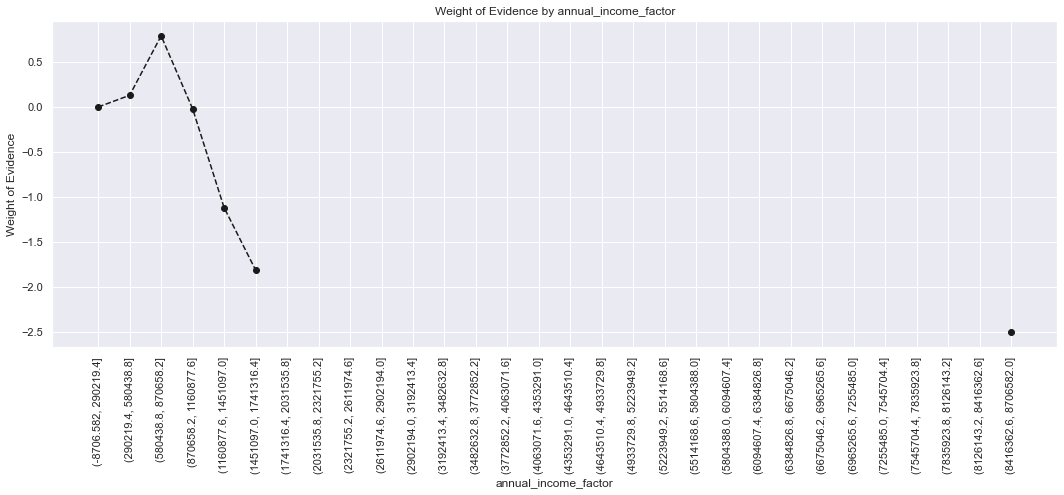

In [265]:
plot_by_woe(ann_inc_df, 90)

In [266]:
df_num_tmp = df_num[df_num['annual_inc'] <= 290000].copy()
df_num_tmp['annual_inc_factor'] = pd.cut(df_num_tmp['annual_inc'], 10)
# make sure to select only the relevant indexes in the target column
df_temp = woe_continuous(df_num_tmp, 'annual_inc_factor', Y[df_num_tmp.index])
df_temp


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-290.0, 29000.0]",4213,0.910040,0.053058,3834.0,379.0,0.052229,0.063209,-0.190799,NaN,NaN,0.017582
1,"(29000.0, 58000.0]",28134,0.916720,0.354319,25791.0,2343.0,0.351343,0.390761,-0.106333,0.006680,0.084466,0.017582
2,"(58000.0, 87000.0]",24722,0.924561,0.311348,22857.0,1865.0,0.311374,0.311041,0.001070,0.007841,0.107403,0.017582
3,"(87000.0, 116000.0]",11995,0.934639,0.151065,11211.0,784.0,0.152724,0.130754,0.155315,0.010078,0.154245,0.017582
4,"(116000.0, 145000.0]",5448,0.937408,0.068612,5107.0,341.0,0.069571,0.056871,0.201558,0.002769,0.046243,0.017582
5,"(145000.0, 174000.0]",2355,0.940127,0.029659,2214.0,141.0,0.030161,0.023516,0.248870,0.002719,0.047311,0.017582
6,"(174000.0, 203000.0]",1413,0.949045,0.017795,1341.0,72.0,0.018268,0.012008,0.419578,0.008917,0.170709,0.017582
7,"(203000.0, 232000.0]",562,0.948399,0.007078,533.0,29.0,0.007261,0.004837,0.406299,0.000646,0.013279,0.017582
8,"(232000.0, 261000.0]",393,0.921120,0.004949,362.0,31.0,0.004931,0.005170,-0.047270,0.027279,0.453569,0.017582
9,"(261000.0, 290000.0]",168,0.934524,0.002116,157.0,11.0,0.002139,0.001835,0.153424,0.013404,0.200694,0.017582


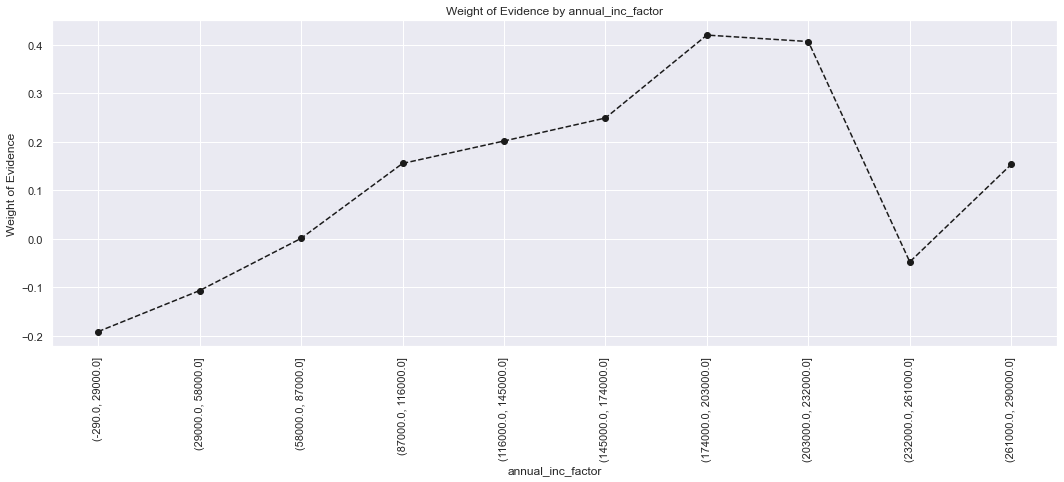

In [267]:
plot_by_woe(df_temp, 90)

In [268]:
df_num.columns

Index(['term', 'annual_inc', 'dti', 'inq_last_6mths', 'inq_last_12m',
       'mths_since_issue_d', 'mths_since_last_credit_pull_d', 'loan_status2',
       'annual_income_factor'],
      dtype='object')

In [269]:
#analyzing inq_last_6mths
df_num['inq_last_6mths_factor'] = pd.cut(df_num['inq_last_6mths'], 6)
inq_fact_df = woe_continuous(df_num, 'inq_last_6mths_factor', Y)
inq_fact_df

,inq_last_6mths_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.006, 1.0]",70052,0.929752,0.875650,65131.0,4921.0,0.880589,0.815140,0.077231,NaN,NaN,0.036044
1,"(1.0, 2.0]",6780,0.896313,0.084750,6077.0,703.0,0.082163,0.116449,-0.348748,0.033439,0.425979,0.036044
2,"(2.0, 3.0]",2272,0.871039,0.028400,1979.0,293.0,0.026757,0.048534,-0.595483,0.025274,0.246735,0.036044
3,"(3.0, 4.0]",647,0.868624,0.008087,562.0,85.0,0.007598,0.014080,-0.616807,0.002414,0.021324,0.036044
4,"(4.0, 5.0]",245,0.861224,0.003063,211.0,34.0,0.002853,0.005632,-0.680160,0.007400,0.063353,0.036044
5,"(5.0, 6.0]",4,0.750000,0.000050,3.0,1.0,0.000041,0.000166,-1.407045,0.111224,0.726885,0.036044


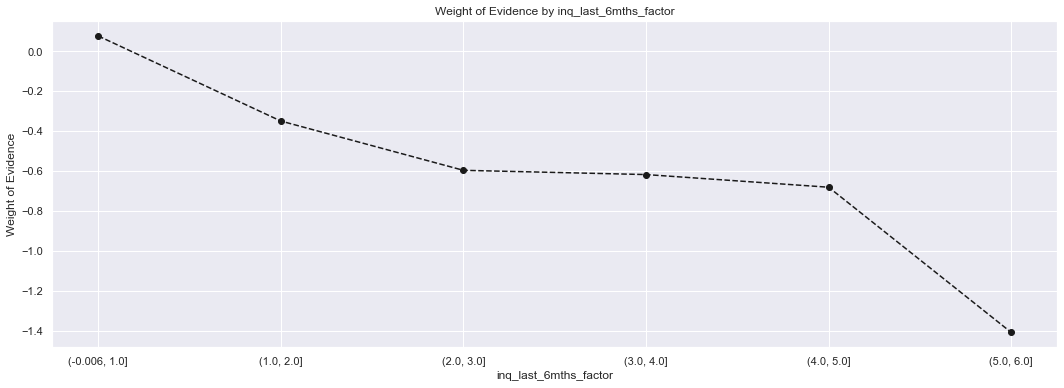

In [270]:
plot_by_woe(inq_fact_df)

In [272]:
#analyzing inq_last_12mths
df_num['inq_last_12m_factor'] = pd.cut(df_num['inq_last_12m'], 6)
inq_fact12_df = woe_continuous(df_num, 'inq_last_12m_factor', Y)
inq_fact12_df

,inq_last_12m_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.036, 6.0]",77856,0.924643,0.973200,71989.0,5867.0,0.973311,0.971840,0.001512,NaN,NaN,inf
1,"(6.0, 12.0]",1894,0.920803,0.023675,1744.0,150.0,0.023579,0.024847,-0.052356,0.003840,0.053869,inf
2,"(12.0, 18.0]",216,0.912037,0.002700,197.0,19.0,0.002663,0.003147,-0.166893,0.008765,0.114537,inf
3,"(18.0, 24.0]",25,1.000000,0.000313,25.0,0.0,0.000338,0.000000,inf,0.087963,inf,inf
4,"(24.0, 30.0]",5,1.000000,0.000063,5.0,0.0,0.000068,0.000000,inf,0.000000,NaN,inf
5,"(30.0, 36.0]",4,0.750000,0.000050,3.0,1.0,0.000041,0.000166,-1.407045,0.250000,inf,inf


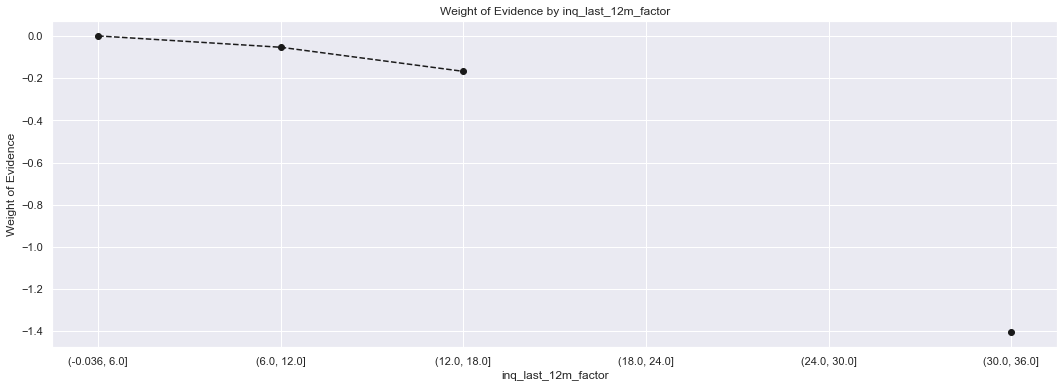

In [273]:
plot_by_woe(inq_fact12_df)

In [274]:
# analyzing dti 
df_num['dti_factor'] = pd.cut(df_num['dti'], 10)
dti_df = woe_continuous(df_num, 'dti_factor', Y)
dti_df

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-9.999, 999.9]",79997,0.924547,0.999962,73961.0,6036.0,0.999973,0.999834,0.000139,NaN,NaN,0.000251
1,"(999.9, 1999.8]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000251
2,"(1999.8, 2999.7]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000251
3,"(2999.7, 3999.6]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000251
4,"(3999.6, 4999.5]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000251
5,"(4999.5, 5999.4]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000251
6,"(5999.4, 6999.3]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000251
7,"(6999.3, 7999.2]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000251
8,"(7999.2, 8999.1]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000251
9,"(8999.1, 9999.0]",3,0.666667,0.000037,2.0,1.0,0.000027,0.000166,-1.812511,NaN,NaN,0.000251


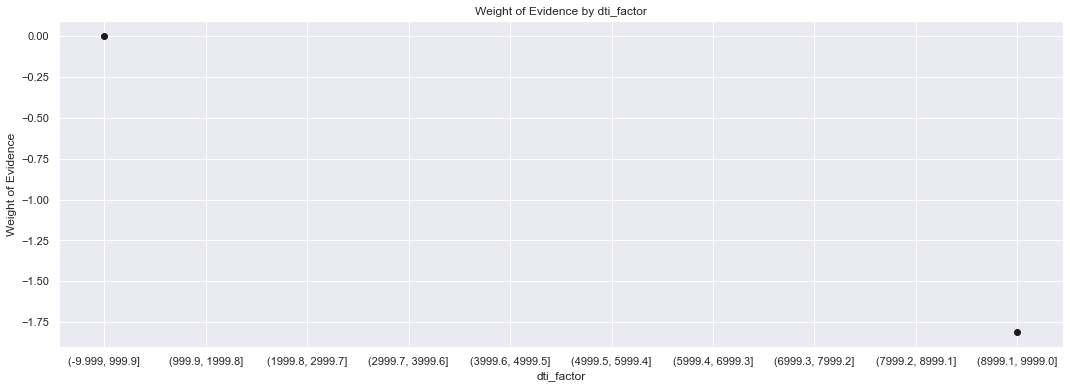

In [275]:
plot_by_woe(dti_df)

In [276]:
df_num.columns

Index(['term', 'annual_inc', 'dti', 'inq_last_6mths', 'inq_last_12m',
       'mths_since_issue_d', 'mths_since_last_credit_pull_d', 'loan_status2',
       'annual_income_factor', 'inq_last_6mths_factor', 'inq_last_12m_factor',
       'dti_factor'],
      dtype='object')

In [277]:
# analyzing mths_since_issue_date 
df_num['mths_since_issue_d_fact'] = pd.cut(df_num['mths_since_issue_d'], 10)
issue_df = woe_continuous(df_num, 'mths_since_issue_d_fact', Y)
issue_df

,mths_since_issue_d_fact,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(4.98, 7.0]",10634,0.980064,0.132925,10422.0,212.0,0.140908,0.035117,1.389430,NaN,NaN,0.308546
1,"(7.0, 9.0]",6402,0.963918,0.080025,6171.0,231.0,0.083434,0.038264,0.779541,0.016146,0.609889,0.308546
2,"(9.0, 11.0]",10449,0.950139,0.130612,9928.0,521.0,0.134229,0.086301,0.441707,0.013779,0.337834,0.308546
3,"(11.0, 13.0]",7664,0.934629,0.095800,7163.0,501.0,0.096846,0.082988,0.154420,0.015509,0.287286,0.308546
4,"(13.0, 15.0]",8741,0.926553,0.109262,8099.0,642.0,0.109501,0.106344,0.029250,0.008076,0.125170,0.308546
5,"(15.0, 17.0]",8352,0.914631,0.104400,7639.0,713.0,0.103281,0.118105,-0.134117,0.011922,0.163367,0.308546
6,"(17.0, 19.0]",8734,0.900962,0.109175,7869.0,865.0,0.106391,0.143283,-0.297701,0.013669,0.163584,0.308546
7,"(19.0, 21.0]",6354,0.878030,0.079425,5579.0,775.0,0.075430,0.128375,-0.531756,0.022932,0.234055,0.308546
8,"(21.0, 23.0]",6352,0.877834,0.079400,5576.0,776.0,0.075389,0.128541,-0.533583,0.000196,0.001827,0.308546
9,"(23.0, 25.0]",6318,0.873219,0.078975,5517.0,801.0,0.074591,0.132682,-0.575929,0.004614,0.042346,0.308546


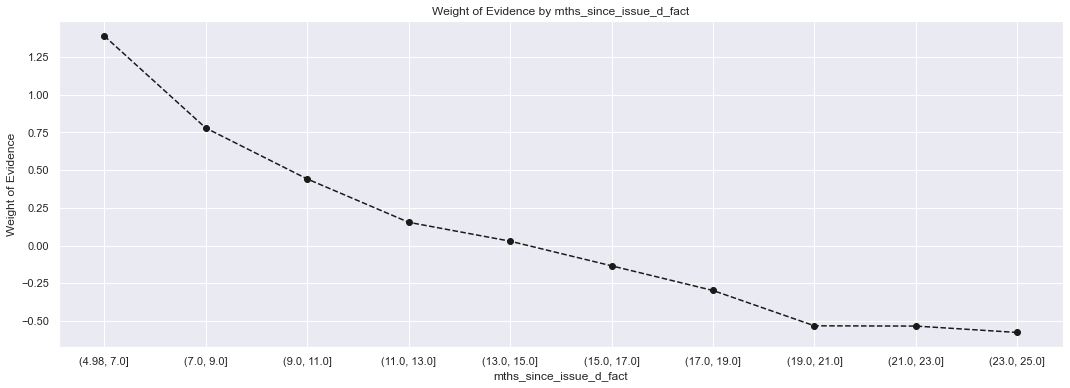

In [278]:
plot_by_woe(issue_df)

In [279]:
# analyzing mths_since_credit_pull 
df_num['mths_since_last_credit_pull_d_factor'] = pd.cut(df_num['mths_since_last_credit_pull_d'], 10)
mths_cr_pull_df = woe_continuous(df_num, 'mths_since_last_credit_pull_d_factor', Y)
mths_cr_pull_df

,mths_since_last_credit_pull_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(1.976, 4.4]",75193,0.921269,0.939913,69273.0,5920.0,0.936590,0.980620,-0.045939,NaN,NaN,0.062173
1,"(4.4, 6.8]",1128,0.988475,0.014100,1115.0,13.0,0.015075,0.002153,1.946003,0.067206,1.991942,0.062173
2,"(6.8, 9.2]",1423,0.977512,0.017788,1391.0,32.0,0.018807,0.005301,1.266385,0.010963,0.679618,0.062173
3,"(9.2, 11.6]",888,0.972973,0.011100,864.0,24.0,0.011682,0.003975,1.077861,0.004539,0.188523,0.062173
4,"(11.6, 14.0]",699,0.974249,0.008738,681.0,18.0,0.009207,0.002982,1.127533,0.001276,0.049672,0.062173
5,"(14.0, 16.4]",247,0.967611,0.003087,239.0,8.0,0.003231,0.001325,0.891364,0.006638,0.236169,0.062173
6,"(16.4, 18.8]",197,0.939086,0.002462,185.0,12.0,0.002501,0.001988,0.229791,0.028525,0.661573,0.062173
7,"(18.8, 21.2]",151,0.960265,0.001888,145.0,6.0,0.001960,0.000994,0.679317,0.021179,0.449525,0.062173
8,"(21.2, 23.6]",55,0.945455,0.000687,52.0,3.0,0.000703,0.000497,0.346974,0.014810,0.332343,0.062173
9,"(23.6, 26.0]",19,0.947368,0.000237,18.0,1.0,0.000243,0.000166,0.384714,0.001914,0.037740,0.062173


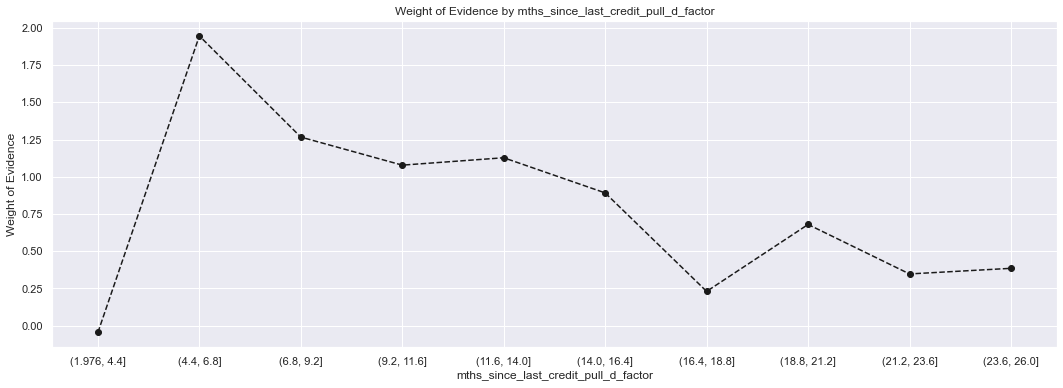

In [280]:
plot_by_woe(mths_cr_pull_df)

## Creating New Features and Final Dataset for Model

**In this section we will assemble a new dataset created by the features engineered above via Woe**

**Perform Monotonic binning with WoE for each numerical variable. We can use the xverse package to do so and look at the unique values within each column**

In [281]:
clf = MonotonicBinning()
clf.fit(df_num, Y)

print(clf.bins)
output_bins = clf.bins 

clf = MonotonicBinning(custom_binning=output_bins) #output_bins was created earlier

out_X = clf.transform(df_num)
out_X.head()

{'term': array([36., 60.]), 'annual_inc': array([      0.,   52000.,   81000., 8706582.]), 'dti': array([   0.  ,   14.53,   22.7 , 9999.  ]), 'inq_last_6mths': array([0., 1., 6.]), 'inq_last_12m': array([ 0.,  1., 36.]), 'mths_since_issue_d': array([ 5., 11., 18., 25.]), 'mths_since_last_credit_pull_d': array([ 1.,  2., 26.]), 'loan_status2': array([0., 1.])}


,term,annual_inc,dti,inq_last_6mths,inq_last_12m,mths_since_issue_d,mths_since_last_credit_pull_d,loan_status2,annual_income_factor,inq_last_6mths_factor,inq_last_12m_factor,dti_factor,mths_since_issue_d_fact,mths_since_last_credit_pull_d_factor
0,60,"(81000.0, 8706582.0]","(22.7, 9999.0]","(-0.001, 1.0]","(-0.001, 1.0]","(4.999, 11.0]","(0.999, 2.0]",1,"(-8706.582, 290219.4]","(-0.006, 1.0]","(-0.036, 6.0]","(-9.999, 999.9]","(4.98, 7.0]","(1.976, 4.4]"
1,60,"(81000.0, 8706582.0]","(-0.001, 14.53]","(-0.001, 1.0]","(1.0, 36.0]","(4.999, 11.0]","(0.999, 2.0]",1,"(-8706.582, 290219.4]","(-0.006, 1.0]","(-0.036, 6.0]","(-9.999, 999.9]","(9.0, 11.0]","(1.976, 4.4]"
2,60,"(81000.0, 8706582.0]","(22.7, 9999.0]","(-0.001, 1.0]","(1.0, 36.0]","(11.0, 18.0]","(0.999, 2.0]",1,"(-8706.582, 290219.4]","(-0.006, 1.0]","(-0.036, 6.0]","(-9.999, 999.9]","(11.0, 13.0]","(1.976, 4.4]"
3,36,"(-0.001, 52000.0]","(14.53, 22.7]","(-0.001, 1.0]","(-0.001, 1.0]","(18.0, 25.0]","(2.0, 26.0]",1,"(-8706.582, 290219.4]","(-0.006, 1.0]","(-0.036, 6.0]","(-9.999, 999.9]","(17.0, 19.0]","(1.976, 4.4]"
4,36,"(52000.0, 81000.0]","(22.7, 9999.0]","(1.0, 6.0]","(1.0, 36.0]","(11.0, 18.0]","(0.999, 2.0]",1,"(-8706.582, 290219.4]","(1.0, 2.0]","(-0.036, 6.0]","(-9.999, 999.9]","(11.0, 13.0]","(1.976, 4.4]"


**Look at the unique values within each variable in out_X to see the bins in each variables**

In [282]:
out_X.term.value_counts()

36    56346
60    23654
Name: term, dtype: int64

In [283]:
out_X.annual_inc.value_counts()

(-0.001, 52000.0]       26814
(52000.0, 81000.0]      26650
(81000.0, 8706582.0]    26536
Name: annual_inc, dtype: int64

In [284]:
out_X.dti.value_counts()

(14.53, 22.7]      26685
(-0.001, 14.53]    26681
(22.7, 9999.0]     26634
Name: dti, dtype: int64

In [285]:
out_X.inq_last_6mths.value_counts()

(-0.001, 1.0]    70052
(1.0, 6.0]        9948
Name: inq_last_6mths, dtype: int64

In [286]:
out_X.inq_last_12m.value_counts()

(-0.001, 1.0]    61321
(1.0, 36.0]      18679
Name: inq_last_12m, dtype: int64

In [287]:
out_X.mths_since_issue_d.value_counts()

(11.0, 18.0]     28633
(4.999, 11.0]    27485
(18.0, 25.0]     23882
Name: mths_since_issue_d, dtype: int64

In [288]:
out_X.mths_since_last_credit_pull_d.value_counts()

(0.999, 2.0]    71372
(2.0, 26.0]      8628
Name: mths_since_last_credit_pull_d, dtype: int64

**Initialize empty dataframe**

In [289]:
df_final = pd.DataFrame()
df_final.head()

""


In [294]:
# # home_ownership 
df_final['home_ownership_OWN'] = df_dummies.loc[:, 'home_ownership_OWN']
df_final['home_ownership_RENT_ANY'] = sum([df_dummies.loc[:,'home_ownership_RENT'], df_dummies.loc[:, 'home_ownership_ANY']])
df_final['home_ownership_MORTGAGE'] = df_dummies.loc[:, 'home_ownership_MORTGAGE']

# #verification status
df_final['verification_status_NOT_VERIFIED'] = df_dummies.loc[:, 'verification_status_Not Verified']
df_final['verification_status_SOURCE_VERIFIED'] = df_dummies.loc[:, 'verification_status_Source Verified']
df_final['verification_status_VERIFIED'] = df_dummies.loc[:, 'verification_status_Verified']

# purpose of loan
df_final['purpose_sb_re__moving'] = sum([df_dummies['purpose_small_business'],  df_dummies['purpose_renewable_energy'], df_dummies['purpose_moving']])
df_final['purpose_other_house_medical'] =sum([df_dummies['purpose_other'], df_dummies['purpose_house'], df_dummies['purpose_medical']])
df_final ['purpose_wedding_vacation'] = sum([df_dummies['purpose_wedding'], df_dummies['purpose_vacation']])
df_final['purpose_hi_mp'] = sum([df_dummies['purpose_home_improvement'], df_dummies['purpose_major_purchase']])
df_final ['purpose_car_creditcard'] = sum([df_dummies['purpose_car'], df_dummies['purpose_credit_card']])

#addr_state
df_final['addr_state_NE_NV_HI_FL_AL'] =sum([df_dummies['addr_state_NV'],
                                           df_dummies['addr_state_HI'],df_dummies['addr_state_FL'],df_dummies['addr_state_AL']])
df_final['addr_state_NY'] = df_dummies.loc[:, 'addr_state_NY']
df_final['addr_state_LA_NM_OK_NC_MO_MD_NJ_VA'] = sum([df_dummies['addr_state_LA'],df_dummies['addr_state_NM'],df_dummies['addr_state_OK'],
                     df_dummies['addr_state_NC'],df_dummies['addr_state_MO'],df_dummies['addr_state_MD'], df_dummies['addr_state_NJ'],
                                                  df_dummies['addr_state_VA']])
df_final['addr_state_CA'] = df_dummies.loc[:,'addr_state_CA']
df_final['addr_state_AZ_MI_UT_TN_AR_PA'] =sum([df_dummies['addr_state_AZ'],df_dummies['addr_state_MI'],df_dummies['addr_state_UT'],
df_dummies['addr_state_TN'],df_dummies['addr_state_AR'],df_dummies['addr_state_PA']])

df_final['addr_state_RI_OH_KY_DE_MN_SD_MA_IN'] =sum([df_dummies['addr_state_RI'],df_dummies['addr_state_OH'],df_dummies['addr_state_KY'],
 df_dummies['addr_state_DE'],df_dummies['addr_state_MN'],df_dummies['addr_state_SD'],df_dummies['addr_state_MA'],
                    df_dummies['addr_state_IN']])
df_final['addr_state_GA_WA'] = sum([df_dummies['addr_state_GA'], df_dummies['addr_state_WA']])
df_final['addr_state_WI_OR'] = sum([df_dummies['addr_state_WI'], df_dummies['addr_state_OR']])
df_final['addr_state_TX'] = df_dummies.loc[:,'addr_state_TX']
df_final['addr_state_IL_CT_MT'] =sum([df_dummies['addr_state_IL'],df_dummies['addr_state_CT'],df_dummies['addr_state_MT']])
df_final['addr_state_CO_SC'] = sum([df_dummies['addr_state_CO'], df_dummies['addr_state_SC']])
df_final['addr_state_KS_VT_AK_NS'] =sum([df_dummies['addr_state_KS'],df_dummies['addr_state_VT'],df_dummies['addr_state_AK'],
                                           df_dummies['addr_state_MS']])
df_final['addr_state_NH_WV_WY_DC'] =sum([df_dummies['addr_state_NH'],df_dummies['addr_state_WV'],df_dummies['addr_state_WY'],
                                           df_dummies['addr_state_DC']])

# term 
df_final['term_36'] = np.where((df_num['term'] == 36), 1, 0)
df_final['term_60'] = np.where((df_num['term']==60), 1,0)

#dti 
df_final['dti:<14.53'] = np.where((df_num['dti'] <=14.53), 1, 0)
df_final['dti:14.53-22.7'] = np.where((df_num['dti'] > 14.53) & (df_num['dti'] <= 22.7), 1, 0)
df_final['dti>22.7'] = np.where((df_num['dti'] > 22.7), 1, 0)

#annual income 
df_final['annual_inc:<52000'] = np.where((df_num['annual_inc'] <= 52000), 1, 0) #-0.001, 52000.0
df_final['annual_inc:52000-81000'] = np.where((df_num['annual_inc'] > 52000) & (df_num['annual_inc'] <= 81000),1, 0)
df_final['annual_inc:81000-8706582'] = np.where((df_num['annual_inc'] > 81000) & (df_num['annual_inc'] <= 8706582), 1, 0)

#inq_last_6mths
df_final['inq_last_6mths:<1'] = np.where((df_num['inq_last_6mths'] <=1), 1, 0)
df_final['inq_last_6mths:1-6'] = np.where((df_num['inq_last_6mths'] >1)& (df_num['inq_last_6mths']<=6),  1, 0)

#inq_last_12m
df_final['inq_last_12m:<1'] = np.where((df_num['inq_last_12m'] <=1), 1, 0)
df_final['inq_last_12m:1-36'] = np.where((df_num['inq_last_12m'] >1)& (df_num['inq_last_6mths']<=36),  1, 0)


#mths_since_last_credit_pull_d
df_final['mths_since_last_credit_pull_d:.999-31.5'] = np.where((df_num['mths_since_last_credit_pull_d']<=31.5), 1,0)
df_final['mths_since_last_credit_pull_d:31.5-63.0'] = np.where((df_num['mths_since_last_credit_pull_d']>31.5)&(df_num['mths_since_last_credit_pull_d']<=63),1,0)
df_final['mths_since_last_credit_pull_d:>63'] = np.where((df_num['mths_since_last_credit_pull_d']>63), 1,0)


# #mths_since_issue_d_factor
df_final['mths_since_issue_d_:<72'] = np.where((df_num['mths_since_issue_d']<=72), 1,0)
df_final['mths_since_issue_d_:>72-79'] = np.where((df_num['mths_since_issue_d'] >72) & (df_num['mths_since_issue_d']<=79), 1,0)
df_final['mths_since_issue_d_:79-86'] = np.where((df_num['mths_since_issue_d']>79), 1,0)


df_final['loan_status'] = df_num.loc[:, 'loan_status2']



In [295]:
df_final.head()

,home_ownership_OWN,home_ownership_RENT_ANY,home_ownership_MORTGAGE,verification_status_NOT_VERIFIED,verification_status_SOURCE_VERIFIED,verification_status_VERIFIED,purpose_sb_re__moving,purpose_other_house_medical,purpose_wedding_vacation,purpose_hi_mp,...,inq_last_6mths:1-6,inq_last_12m:<1,inq_last_12m:1-36,mths_since_last_credit_pull_d:.999-31.5,mths_since_last_credit_pull_d:31.5-63.0,mths_since_last_credit_pull_d:>63,mths_since_issue_d_:<72,mths_since_issue_d_:>72-79,mths_since_issue_d_:79-86,loan_status
0,0,1,0,0,0,1,0,0,0,0,...,0,1,0,1,0,0,1,0,0,1
1,0,0,1,0,1,0,0,0,0,1,...,0,0,1,1,0,0,1,0,0,1
2,0,1,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,1
3,0,1,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,1
4,0,0,1,1,0,0,0,0,0,0,...,1,0,1,1,0,0,1,0,0,1


In [296]:
df_final.shape

(80000, 43)

## Model Building

In [297]:
#identify predictors and target variables
X = df_final.loc[:, df_final.columns != 'loan_status']
Y = df_final.loan_status

#split data into training and test set using 80/20 rule
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

<AxesSubplot:title={'center':'Class Balance for Training Data set - Targer Variable'}>

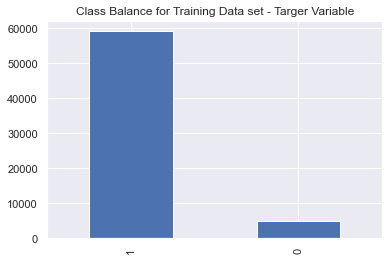

In [298]:
#check for imbalance in training dataset
y_train.value_counts().plot(kind = 'bar', title = 'Class Balance for Training Data set - Targer Variable')

In [299]:
#check for imbalance in training dataset
y_train.value_counts()

1    59194
0     4806
Name: loan_status, dtype: int64

In [300]:
lr = LogisticRegression(solver='liblinear', class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.11      0.58      0.18      1231
           1       0.94      0.59      0.73     14769

    accuracy                           0.59     16000
   macro avg       0.53      0.59      0.45     16000
weighted avg       0.88      0.59      0.69     16000



In [301]:
y_test_hat_proba = lr.predict_proba(X_test)
y_test_hat_pay_proba = y_test_hat_proba[:][: , 1] #probability of paying loan
y_test_hat_default_proba = y_test_hat_proba[:][: , 0] #probability of defaulting, this is our Probability of default!
y_test_tmp = y_test.copy()
y_test_tmp.reset_index(drop = True, inplace = True)
y_test_prob = pd.concat([y_test_tmp, pd.DataFrame(y_pred), pd.DataFrame(y_test_hat_pay_proba), pd.DataFrame(y_test_hat_default_proba)], axis = 1)
y_test_prob.columns = ['Actual Outcome', 'Model Prediction', 'Probability of Paying Loan', 'Probability of Default']
y_test_prob.index = X_test.index
y_test_prob.head()

,Actual Outcome,Model Prediction,Probability of Paying Loan,Probability of Default
17725,1,1,0.673608,0.326392
76350,1,0,0.370360,0.629640
42814,1,1,0.757664,0.242336
14944,1,1,0.614871,0.385129
48349,1,1,0.656363,0.343637


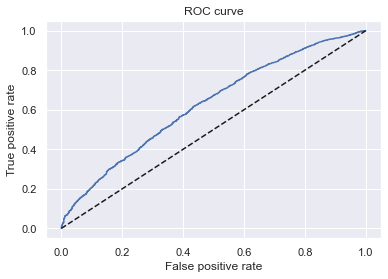

In [303]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_prob['Actual Outcome'], y_test_prob['Probability of Paying Loan'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, to plot randomness of model
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
plt.show()



In [304]:
#Area under receiver operating charateristic cure
AUROC = roc_auc_score(y_test_prob['Actual Outcome'], y_test_prob['Probability of Paying Loan'])
AUROC

0.6267001671393398

In [305]:
gini_coef = AUROC * 2-1
gini_coef

0.2534003342786797

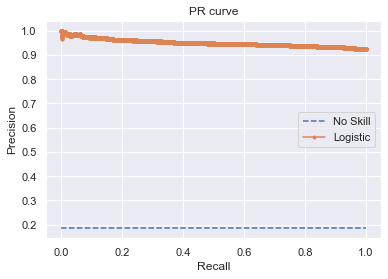

In [330]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(Y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_prob['Actual Outcome'], y_test_prob['Probability of Paying Loan'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [331]:
#precision recall score
auc_pr = auc(recall, precision)
auc_pr

0.9500508261783668

**Perhaps we can further increase the performance of it by oversampling and balancing our training sets. We will compare at the end**

In [332]:
os = RandomOverSampler()
X_train_o, y_train_o = os.fit_resample(X_train, y_train)
y_train_series = pd.Series(y_train_o)

y_train_series.value_counts()

0    59194
1    59194
Name: loan_status, dtype: int64

In [333]:
model = LogisticRegression()
model.fit(X_train_o, y_train_o)
y_preds = model.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.11      0.58      0.18      1231
           1       0.94      0.59      0.73     14769

    accuracy                           0.59     16000
   macro avg       0.53      0.59      0.45     16000
weighted avg       0.88      0.59      0.69     16000



In [334]:
y_test_hat_proba2 = model.predict_proba(X_test)
y_test_hat_pay_proba2 = y_test_hat_proba2[:][: , 1] #probability of paying loan
y_test_hat_default_proba2 = y_test_hat_proba2[:][: , 0] #probability of defaulting, this is our Probability of default!
y_test_tmp2 = y_test.copy()
y_test_tmp2.reset_index(drop = True, inplace = True)
y_test_prob2 = pd.concat([y_test_tmp2, pd.DataFrame(y_preds), pd.DataFrame(y_test_hat_pay_proba2), pd.DataFrame(y_test_hat_default_proba2)], axis = 1)
y_test_prob2.columns = ['Actual Outcome', 'Model Prediction', 'Probability of Paying Loan', 'Probability of Default']
y_test_prob2.index = X_test.index
y_test_prob2.head()

,Actual Outcome,Model Prediction,Probability of Paying Loan,Probability of Default
17725,1,1,0.671305,0.328695
76350,1,0,0.373480,0.626520
42814,1,1,0.753372,0.246628
14944,1,1,0.608884,0.391116
48349,1,1,0.649841,0.350159


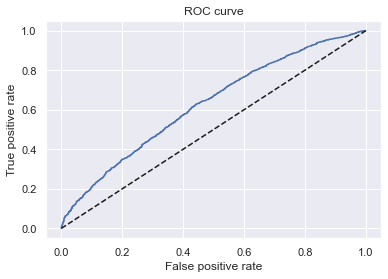

In [335]:
# get the values required to plot a ROC curve
fpr2, tpr2, thresholds2 = roc_curve(y_test_prob2['Actual Outcome'], y_test_prob2['Probability of Paying Loan'])
# plot the ROC curve
plt.plot(fpr2, tpr2)
# plot a secondary diagonal line, to plot randomness of model
plt.plot(fpr2, fpr2, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
plt.show()

In [336]:
#Area under receiver operating charateristic cure
AUROC2 = roc_auc_score(y_test_prob2['Actual Outcome'], y_test_prob2['Probability of Paying Loan'])
AUROC2

0.6268114393558994

In [337]:
Gini2 = AUROC2 * 2 - 1
Gini2

0.2536228787117989

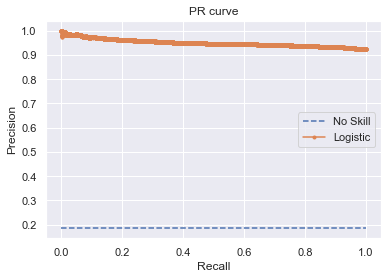

In [338]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(Y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_prob2['Actual Outcome'], y_test_prob2['Probability of Paying Loan'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [339]:
#precision recall score
auc_pr = auc(recall, precision)
auc_pr

0.9500530915499035

## Model Discussion

-Your choice of the classification method that you believe would best perform with this dataset. <br>
-Any additional data challenges you may face given your choice of modeling methodology. <br>
-The final list of variables that would go into your model after performing any variable selection technique that you deem necessary. <br>
-How you would validate the model. 

### Why Logistic Regression?

**We developed a logistic regression model given the binary nature of the outcome variable. Originally, yes, the outcome variable, loan_status, was made up of multiple classes, however we were ultimately trying to measure the probability of defaulting (0) or being paid (1). Moreover, logistic regression leads to more simply interpretable results. <br>
There were two versions of this model tested, one that did not oversample and one that did oversample in order to create a balanced training dataset. Based on our evaluation metrics, which will be discussed below, the model that did not utilize an oversampling and inherently more balanced training dataset performed slightly better than the one that did.**

### Data Challenges

The main challenge of building the logistic regression was that the outcome class was imbalanced. This is a challenge because we do not want the model to assign 1s to an individual simply because there are more 1s in the training dataset. This would imply that the model is not actually learning but really just classifying based on random chance. Additionally, we must assume that the data is linearly separable to use logistic regression

### Final List of Variables

In [316]:
df_final.columns

Index(['home_ownership_OWN', 'home_ownership_RENT_ANY',
       'home_ownership_MORTGAGE', 'verification_status_NOT_VERIFIED',
       'verification_status_SOURCE_VERIFIED', 'verification_status_VERIFIED',
       'purpose_sb_re__moving', 'purpose_other_house_medical',
       'purpose_wedding_vacation', 'purpose_hi_mp', 'purpose_car_creditcard',
       'addr_state_NE_NV_HI_FL_AL', 'addr_state_NY',
       'addr_state_LA_NM_OK_NC_MO_MD_NJ_VA', 'addr_state_CA',
       'addr_state_AZ_MI_UT_TN_AR_PA', 'addr_state_RI_OH_KY_DE_MN_SD_MA_IN',
       'addr_state_GA_WA', 'addr_state_WI_OR', 'addr_state_TX',
       'addr_state_IL_CT_MT', 'addr_state_CO_SC', 'addr_state_KS_VT_AK_NS',
       'addr_state_NH_WV_WY_DC', 'term_36', 'term_60', 'dti:<14.53',
       'dti:14.53-22.7', 'dti>22.7', 'annual_inc:<52000',
       'annual_inc:52000-81000', 'annual_inc:81000-8706582',
       'inq_last_6mths:<1', 'inq_last_6mths:1-6', 'inq_last_12m:<1',
       'inq_last_12m:1-36', 'mths_since_last_credit_pull_d:.999-31

**The above variables were included in the model. As mentioned earlier, we first utilzied the ANOVA F-Statistic for numerical values and the Chi-Square test for categorical variables to determine what variables are most dependent on the outcome variable. Those that returned lower values were dropped from the dataset. Furthermore, we also tested for multicollinearity, and those that showed high correlation with each other were dropped as well. You will notice that some variables were binned in the final dataset. We used WoE and IV values to combine those variables that had similar WoE values as they have similar predictive powers for the outcome variable.**

### Model Evaluation

In order to evaluate this model, several values were determined. One thing to note is that this data is imbalanced, so we must be careful in picking evaluation metrics.

**AUCROC**: The AUCROC Value describes how well the model can distinguish between the two classes across difference thresholds of the False Positive and True Positive rate.  In the first model we see an AUCROC score of 0.6267001671393398 and in the second model a score of 0.6266801458408585.

**Gini Coefficient**: Given that our class values for the target variable (loan_status) is imbalanced, the Gini Coefficient is a good metric to use. Mathematically, it is nearly equivalent of the AUC. In regards to a business model, we want to make our lending business profitable, meaning we have to consider the disparity between people who pay their loans vs. those who default. So, when we calculate the Gini Coefficient, we are looking to see how well the model discriminates the two. In the first model, we received a Gini coefficient of 0.2534003342786797 and in the second model we received a coefficient of 0.25279342491757295. 

**AUC**: The AUC is arguably the most important metric here. The AUC measures how well the model distinguishes between. This is important for our dataset because we want to see how well the model classifies individuals due to understanding the patterns in the data as opposed to random chance (ie: is the model assigning 1s because there were so many more 1s in the training data or because it understands the features and their predictive power for the outcome). We prefer this over accuracy to evaluate the model as accuracy could be skewed due to the model classifying people due to random chance. In the first model, we receive an AUC of **0.9500508261783668** and in the second model we receive an AUC of  **0.9500530915499035**

**PR Curve**: We visualized the Precision-Recall score to show how the choice of threshold affects classifier performance. This "threshold" is the probability of being positive, or probability that someone ***pays*** their loan. So in both models, the PR-Curve is measure the this probability based on varying levels of precision and recall. We compare it to the no-skill line, as in a hypothetical classifier that cannot discriminate between classes and would predict a random class or a constant class in **all** cases. In both, it seems that our PR Curve performs significantly better than the no-skill classifier as they are on opposite sides of the chart.